<a href="https://colab.research.google.com/github/aboltCD/aboltCD/blob/main/Regresi%C3%B3n_Log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regresión Logística

En este notebook haremos predicciones sobre cáncer de mamas en base propiedades de sus tumores utilizando Regresiones Logísticas.

Sin embargo, el plato fuerte esta vez es el uso de validación cruzada para estabilizar los resultados al disminuir los sesgos de seleccion de datos y la optimización de hiperparámetros.

Comenzamos por importar las librerías necesarias:

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

#import warnings
#warnings.filterwarnings('ignore')

Ahora cargamos el dataset del cancer, lo separamos en Features y Target, lo escalamos y dividimos en entrenamiento y prueba (en este caso, utilizamos un 10% de los datos como prueba):

In [39]:
cancer = load_breast_cancer()

#separamos en features y target

df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
df["cancer"] = cancer.target

#Feature Matrix (todos los atributos)
X = df.drop("cancer",1)  

#Target Variable
y = df[["cancer"]]   
   
#separamos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, random_state = 1)

#escalamos solo los features X (y es una categoría, por lo que no debe ser escalada)
scalerX = StandardScaler().fit(X_train)

X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)



Ahora, buscamos los mejores parámetros para la regresión logística utilizando Grid Search Cross Validation para buscar el mejor parámetro en una "Grilla" de posibles candidatos (combinaciones de valores de parámetros) en donde cáda candidato será evaluado con validación cruzada.

Notemos ahora que LogisticRegression sólo usa la configuración OVR (One vs Rest) ya que es un problema de clasificación binaria. 

Además, notemos que el "param grid" tiene varias configuraciones. Esto se debe a que algunos solvers no soportan regularizaciones lasso, ridge, o elasticnet:

In [40]:
param_grid = [
    {'penalty': ['l1'] , 'solver': ['liblinear', 'saga'], 'C': [100, 50, 20, 10, 5, 1, 0.5, 0.3, 0.2, 0.1]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': [100, 50, 20, 10, 5, 1, 0.5, 0.3, 0.2, 0.1]},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'], 'C': [100, 50, 20, 10, 5, 1, 0.5, 0.3, 0.2, 0.1]},
    {'penalty': ['none'], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}, 
 ]

reglog = GridSearchCV(estimator = LogisticRegression( multi_class = 'ovr'), param_grid = param_grid, scoring = 'accuracy', cv=10) 

reglog.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [100, 50, 20, 10, 5, 1, 0.5, 0....
                          'penalty': ['l1'], 'solver': ['liblinear', 'saga']},
                         {'C': [100, 50, 20, 10, 5, 1, 0.5, 0.3, 0.2, 0.1],
                          'penalty': ['elasticnet'], 'solver': ['saga']},
                         {'C': [100, 50, 20, 10, 5, 1, 0.

In [41]:
print("Mejor score (accuracy): ", reglog.best_score_)
print("Mejores hiperparámetros: ", reglog.best_params_)
print("Mejor modelo: ", reglog.best_estimator_)

best_model = reglog.best_estimator_

Mejor score (accuracy):  0.9747360482654599
Mejores hiperparámetros:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor modelo:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


Ahora podemos obtener el mejor "modelo". No olvidemos reentrenarlo con los datos de entrenamiento completos. Queremos utilizar sólo los hiperparámetros de este mejor modelo. Luego imprimimos sus scores finales con respecto a los datos de prueba.

In [42]:
best_model.fit(X_train,y_train.values.ravel())

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=cancer.target_names))

              precision    recall  f1-score   support

   malignant       1.00      1.00      1.00        23
      benign       1.00      1.00      1.00        34

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



Ahora, imprimimos la curva ROC del clasificador, lo que nos muestra que es bastante bueno:

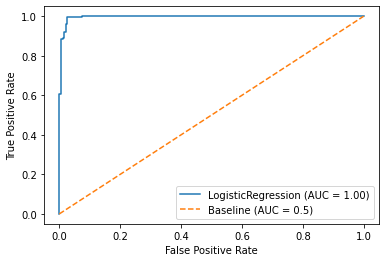

In [47]:
plot_roc_curve(best_model, X_train, y_train)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();